In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from config import model_train_dir, model_test_dir

In [10]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# # Define train and test data generators
# train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2 
# )

train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                    rotation_range=15,  
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   brightness_range=[0.5, 1.5],
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    model_train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed = 42
)

validation_generator = train_datagen.flow_from_directory(
    model_train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    model_test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed = 42
)

Found 2111 images belonging to 19 classes.
Found 518 images belonging to 19 classes.
Found 666 images belonging to 19 classes.


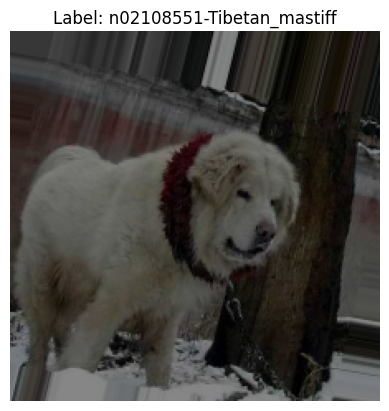

In [12]:
import matplotlib.pyplot as plt

batch = next(train_generator)

images = batch[0]
labels = batch[1]

class_labels = train_generator.class_indices

image = images[0]
label_index = labels[0].argmax()  
label = [key for key, value in class_labels.items() if value == label_index][0]

plt.imshow(image)
plt.title('Label: ' + label)
plt.axis('off')
plt.show()

In [13]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="imagenet",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inp, outp)
for layer in model.layers[:20]:
    layer.trainable = True
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [15]:
checkpoint = ModelCheckpoint('dog_breed_classifier_model_augmented.keras',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stop, reduce_lr]

In [16]:
history3 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks)

Epoch 1/20


/Users/skyglow/Documents/Coding/git/OMSA/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.1906 - loss: 2.8206
Epoch 1: val_acc improved from -inf to 0.06641, saving model to dog_breed_classifier_model_augmented.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - acc: 0.1920 - loss: 2.8139 - val_acc: 0.0664 - val_loss: 35.3546 - learning_rate: 0.0010
Epoch 2/20
 1/65 ━━━━━━━━━━━━━━━━━━━━ 4:42 4s/step - acc: 0.1875 - loss: 1.9952

2024-04-27 15:29:16.893160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-04-27 15:29:17.080589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_acc did not improve from 0.06641

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.1875 - loss: 1.9952 - val_acc: 0.0000e+00 - val_loss: 38.3475 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.4755 - loss: 1.6003
Epoch 3: val_acc improved from 0.06641 to 0.34766, saving model to dog_breed_classifier_model_augmented.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - acc: 0.4762 - loss: 1.5975 - val_acc: 0.3477 - val_loss: 2.2453 - learning_rate: 2.0000e-04
Epoch 4/20
 1/65 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - acc: 0.5938 - loss: 1.2360
Epoch 4: val_acc improved from 0.34766 to 0.50000, saving model to dog_breed_classifier_model_augmented.keras


2024-04-27 15:33:52.589562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-27 15:33:52.749889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.5938 - loss: 1.2360 - val_acc: 0.5000 - val_loss: 2.8050 - learning_rate: 2.0000e-04
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6355 - loss: 1.0300
Epoch 5: val_acc improved from 0.50000 to 0.55859, saving model to dog_breed_classifier_model_augmented.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - acc: 0.6353 - loss: 1.0303 - val_acc: 0.5586 - val_loss: 1.1463 - learning_rate: 4.0000e-05
Epoch 6/20
 1/65 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - acc: 0.4688 - loss: 1.2527
Epoch 6: val_acc improved from 0.55859 to 0.83333, saving model to dog_breed_classifier_model_augmented.keras


2024-04-27 15:38:26.567389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-27 15:38:26.717243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.4688 - loss: 1.2527 - val_acc: 0.8333 - val_loss: 0.8049 - learning_rate: 4.0000e-05
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6246 - loss: 1.0087
Epoch 7: val_acc did not improve from 0.83333

Epoch 7: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
65/65 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - acc: 0.6249 - loss: 1.0082 - val_acc: 0.6719 - val_loss: 0.9464 - learning_rate: 4.0000e-05
Epoch 8/20
 1/65 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - acc: 0.6250 - loss: 0.9898
Epoch 8: val_acc did not improve from 0.83333
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.6250 - loss: 0.9898 - val_acc: 0.8333 - val_loss: 1.1372 - learning_rate: 8.0000e-06
Epoch 9/20


2024-04-27 15:42:51.550327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-27 15:42:51.708389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6699 - loss: 0.9101
Epoch 9: val_acc did not improve from 0.83333

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
65/65 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - acc: 0.6698 - loss: 0.9101 - val_acc: 0.6777 - val_loss: 0.8711 - learning_rate: 8.0000e-06
Epoch 10/20
 1/65 ━━━━━━━━━━━━━━━━━━━━ 4:50 5s/step - acc: 0.6562 - loss: 0.7972
Epoch 10: val_acc did not improve from 0.83333
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.6562 - loss: 0.7972 - val_acc: 0.5000 - val_loss: 1.3129 - learning_rate: 1.6000e-06
Epoch 11/20


2024-04-27 15:47:26.990713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-27 15:47:27.150896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6790 - loss: 0.8789
Epoch 11: val_acc did not improve from 0.83333

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
65/65 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - acc: 0.6789 - loss: 0.8792 - val_acc: 0.6992 - val_loss: 0.8671 - learning_rate: 1.6000e-06


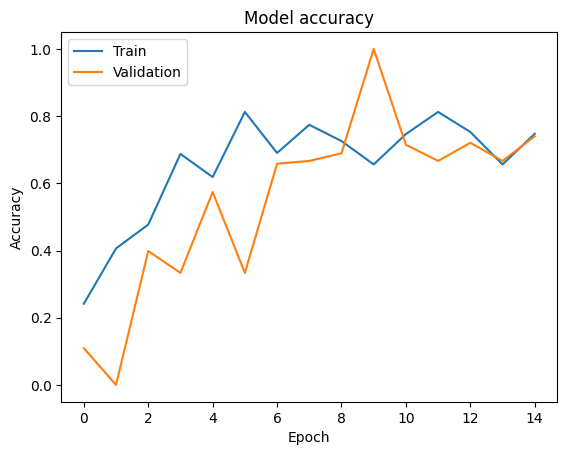

In [7]:
# Plot training & validation accuracy values
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

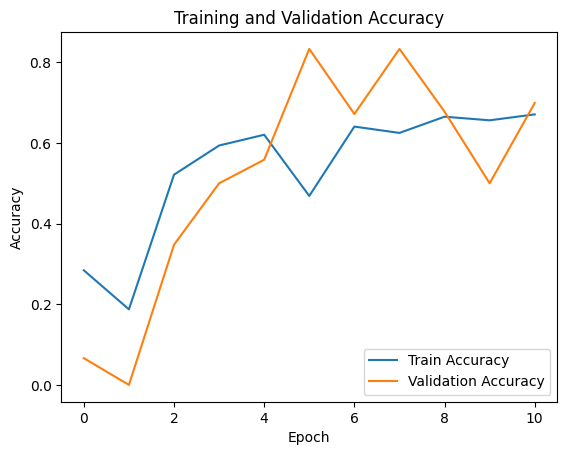

In [26]:
# Plot training & validation accuracy values
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [21]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 25,697,659 (98.03 MB)

 Trainable params: 8,538,003 (32.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 17,076,008 (65.14 MB)